In [13]:

import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.ticker as mticker 
import os 
import mesa_reader as mr 


import utils.load_data as load_data
import utils.plotting.profile_plotting as profile_plotting 
import utils.plotting.history_plotting as history_plotting 
import utils.plotting.HR_diagram_plotting as HR_diagram_plotting
import utils.config.ui_options as ui_options 
import utils.config.plot_options as plot_options
import utils.config.stellar_evolution_data as stellar_evolution_data 



# Automatically reload modules 
%load_ext autoreload 
%autoreload 2 

# Make matplotlib plots open in a separate interactive window 
%matplotlib qt 



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
plt.figure(figsize=(10, 7))

history = load_data.load_history(stellar_evolution_data.data_folder / "M=10.0") 
plt.plot(history.star_age/1e6, 10**history.log_L, lw=3, label="Nonrotating ($\Omega = 0.0$)")

history = load_data.load_history(stellar_evolution_data.data_folder / "M=10.0 omega=0.7") 
plt.plot(history.star_age/1e6, 10**history.log_L, lw=3, label="Rotating ($\Omega = 0.7$)")

plt.tick_params(labelsize=14) 
plt.grid(alpha=0.5)
plt.title("Rotating vs nonrotating star (M = 10 $M_{sun}$)", fontsize=20, pad=20)
plt.xlabel("Age (million years)", fontsize=18, labelpad=14) 
plt.ylabel("Luminosity ($L_{sun}$)", fontsize=18, labelpad=14)
plt.ylim((0, 1.5e4))
plt.xlim((0, plt.gca().get_xlim()[1]))
plt.legend(fontsize=14) 



plt.savefig("L_vs_time_for_nonrotating_vs_rotating_star2.jpg", dpi=300)


In [70]:
hr = HR_diagram_plotting.HRDiagram() 
hr.label_spectraltypes(hr.ax) 

In [48]:
history = load_data.load_history(stellar_evolution_data.data_folder / "M=10.0") 

_ = history_plotting.HistoryPlot.composition(history, modelnum_now=300) 






In [94]:

# for spectral_type in plot_options.SPECTRAL_TYPES: 
#     print(spectral_type.letter, spectral_type.MS_mass_range, spectral_type.temp_range)


fig, ax = plt.subplots(figsize=(12,8)) 
plt.loglog([], []) 
plt.ylim((15, 0.09))
plt.grid() 


plt.xlim((15, 0.09))
# plt.xlim((0.09, 15))


HR_diagram_plotting.HRDiagram.label_spectraltypes(ax, attribute="mass") 


In [233]:


from dataclasses import dataclass

@dataclass 
class Player: 
    name: str 
    career_length: int 
    finals_wins: int 
    finals_appearances: int 
    conference_finals_appearances: int 
    second_round_appearances: int 
    playoff_appearances: int 

Lebron = Player(
    name="Lebron", 
    career_length=22, 
    finals_wins=4, 
    finals_appearances=10, 
    conference_finals_appearances=12, 
    second_round_appearances=15,
    playoff_appearances=18) 

Jordan = Player(
    name="Jordan", 
    career_length=15, 
    finals_wins=6, 
    finals_appearances=6, 
    conference_finals_appearances=8, 
    second_round_appearances=10, 
    playoff_appearances=13)




arr = np.array([0]*14 + [1]*8 + [2]*4 + [3]*2 + [4] + [5])

careers_matched = 0 
for _ in range(100): 
    careers_simulated = 10_000_000  
    for player in [Jordan]:
        records = np.random.choice(arr, size=(careers_simulated, player.career_length))

        finals_wins = np.sum(records == 5, axis=1)
        finals_appearances = finals_wins + np.sum(records == 4, axis=1) 
        conference_finals_appearances = finals_appearances + np.sum(records == 3, axis=1) 
        second_round_appearances = conference_finals_appearances + np.sum(records == 2, axis=1) 
        playoff_appearances = second_round_appearances + np.sum(records == 1, axis=1)

        careers_matched_new = np.sum(
            (finals_wins >= player.finals_wins) &
            (finals_appearances >= player.finals_appearances) & 
            (conference_finals_appearances >= player.conference_finals_appearances) & 
            (second_round_appearances >= player.second_round_appearances) & 
            (playoff_appearances >= player.playoff_appearances)
        )
        careers_matched += careers_matched_new 
        print(_)

print(f"{player.name}: {careers_matched/careers_simulated*100:.10f}% ({careers_matched}/{careers_simulated})") 





0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Jordan: 0.0018100000% (181/10000000)


In [ ]:
# Lebron: 0.0055% (5477/100000000)
# Jordan: 0.0088% (8834/100000000) 


0.0625

In [227]:
import numpy as np
import math

# probabilities per round
# 0 = missed playoffs, 1 = made playoffs, 2 = 2nd round, 3 = conf finals, 4 = finals, 5 = finals win
# Each is a conditional probability relative to the previous stage
p_playoffs = 16/30
p_second = 8/16
p_conf = 4/8
p_finals = 2/4
p_win = 1/2

p_per_season = np.array([
    1 - p_playoffs,  # missed playoffs
    p_playoffs - p_playoffs*p_second,  # made playoffs but not 2nd round
    p_playoffs*p_second - p_playoffs*p_second*p_conf,  # 2nd round but not conf finals
    p_playoffs*p_second*p_conf - p_playoffs*p_second*p_conf*p_finals,  # conf finals but not finals
    p_playoffs*p_second*p_conf*p_finals - p_playoffs*p_second*p_conf*p_finals*p_win,  # finals loss
    p_playoffs*p_second*p_conf*p_finals*p_win  # finals win
])

def multinomial_prob(n, counts, p):
    coeff = math.factorial(n)
    for c in counts:
        coeff //= math.factorial(c)
    return coeff * np.prod(p**counts)

def generate_counts(n, num_outcomes):
    """Recursive generator for multinomial counts summing to n"""
    if num_outcomes == 1:
        yield [n]
    else:
        for i in range(n+1):
            for rest in generate_counts(n-i, num_outcomes-1):
                yield [i] + rest

def prob_at_least(n_seasons, min_playoffs, min_second, min_conf, min_finals, min_wins):
    prob = 0.0
    for counts in generate_counts(n_seasons, 6):
        counts = np.array(counts)
        c1 = counts[1] + counts[2] + counts[3] + counts[4] + counts[5]  # made playoffs
        c2 = counts[2] + counts[3] + counts[4] + counts[5]  # 2nd round+
        c3 = counts[3] + counts[4] + counts[5]  # conf finals+
        c4 = counts[4] + counts[5]  # finals appearance
        c5 = counts[5]  # finals win

        if (c1 >= min_playoffs and
            c2 >= min_second and
            c3 >= min_conf and
            c4 >= min_finals and
            c5 >= min_wins):
            prob += multinomial_prob(n_seasons, counts, p_per_season)
    return prob

prob_lebron = prob_at_least(
    n_seasons=22,
    min_playoffs=18,
    min_second=15,
    min_conf=12,
    min_finals=10,
    min_wins=4
)

prob_jordan = prob_at_least(
    n_seasons=15,
    min_playoffs=13,
    min_second=10,
    min_conf=8,
    min_finals=6,
    min_wins=6  
)

print("LeBron prob at least:", prob_lebron)
print("Jordan prob at least:", prob_jordan)
print("ratio (LeBron / Jordan):", prob_lebron / prob_jordan)



LeBron prob at least: 1.6559615684917002e-08
Jordan prob at least: 1.8564747774230868e-07
ratio (LeBron / Jordan): 0.08919924949318662


0.0018499999999999999

2.0

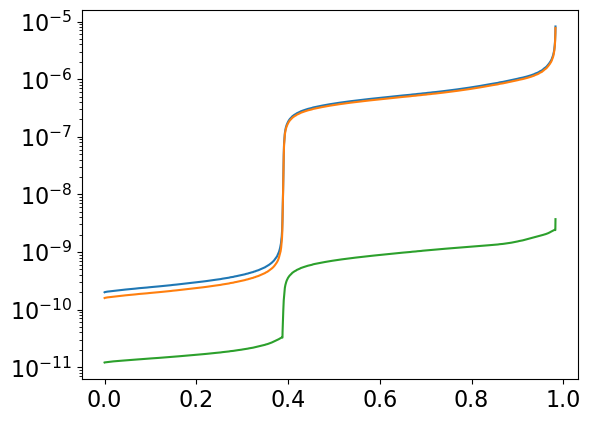

In [35]:

electron_spacing = ( (10**profile.logRho * profile.ye) / (profile.mu*m_p) )**(-1/3)

baryon_spacing = ( (10**profile.logRho) / (profile.mu*m_p) )**(-1/3)

KE_per_N = 3/2 * profile.pressure * profile.mu*m_p / (10**profile.logRho)
p = np.sqrt(2 * KE_per_N * (profile.mu*m_p))
lambda_db = h/p 


plt.plot(profile.mass, electron_spacing)
plt.plot(profile.mass, baryon_spacing)
plt.plot(profile.mass, lambda_db)

plt.yscale("log") 



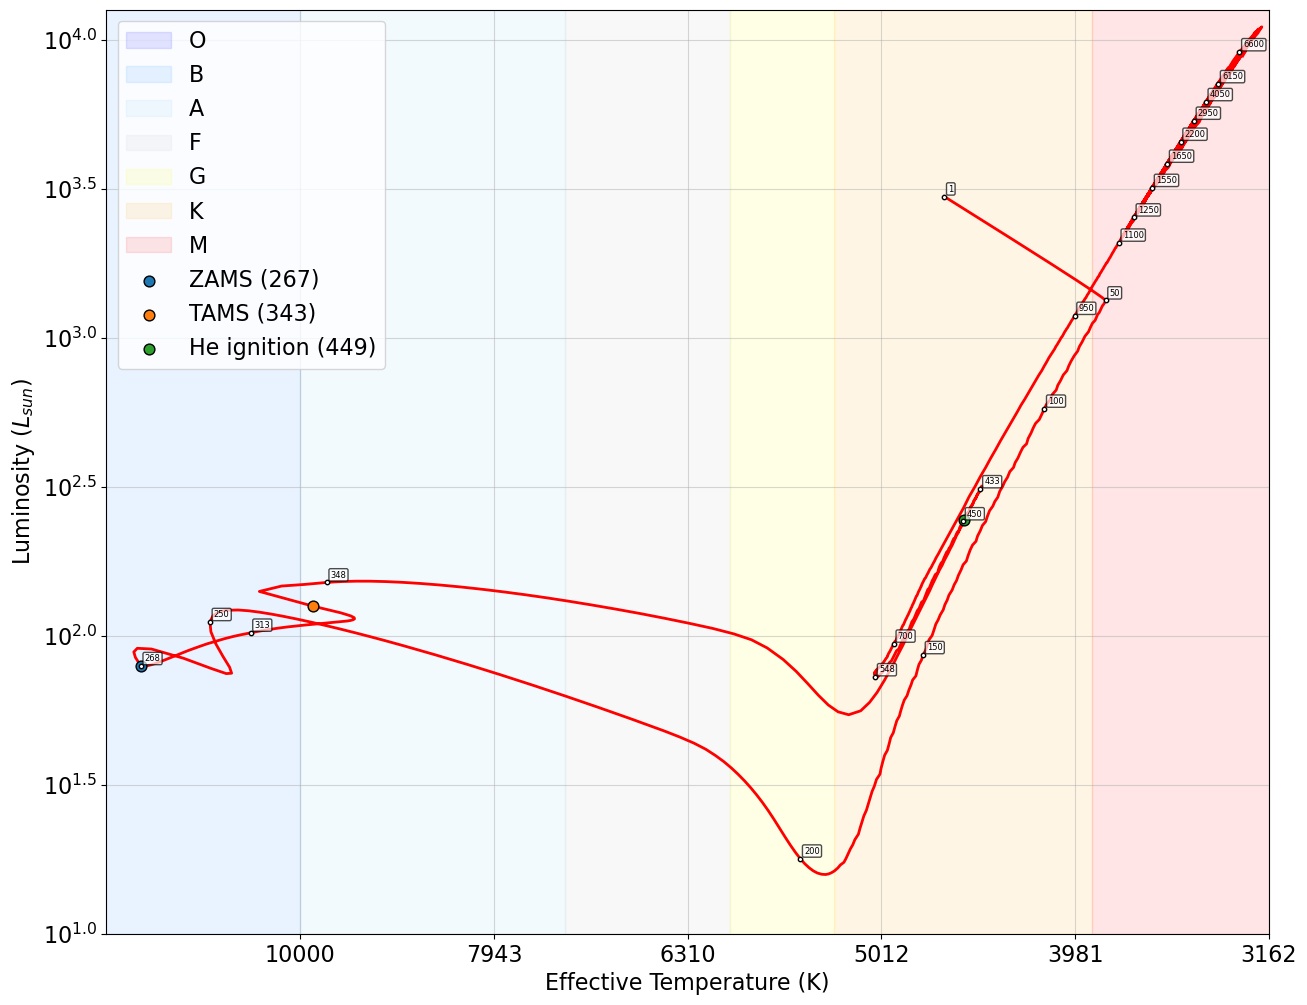

In [2]:



M = 3.0 
history = load_history(M)



# plot_HR_diagram(history)  
plot_HR_diagram(history, T_max=12589, T_min=3162, logL_min=1, logL_max=4.1) 






In [53]:
2.5*np.log10(1.5)

0.4402281476392031

In [182]:
# Composition vs time 

# plot_composition(0.1) 

# plot_composition(0.2) 

# plot_composition(0.5) 

# plot_composition(1) 
# plot_composition(1, xmin=1.235e10, xmax=1.248e10) 

# plot_composition(3) 
  
# plot_composition(10)  
# plot_composition(10, xmin=18e6, xmax=23e6)  
# plot_composition(10, xmin=22.8e6, xmax=22.825e6)  

# plot_composition(30) 

# plot_composition(60) 
# plot_composition(60, xmin=3.2e6, xmax=3.6e6) 




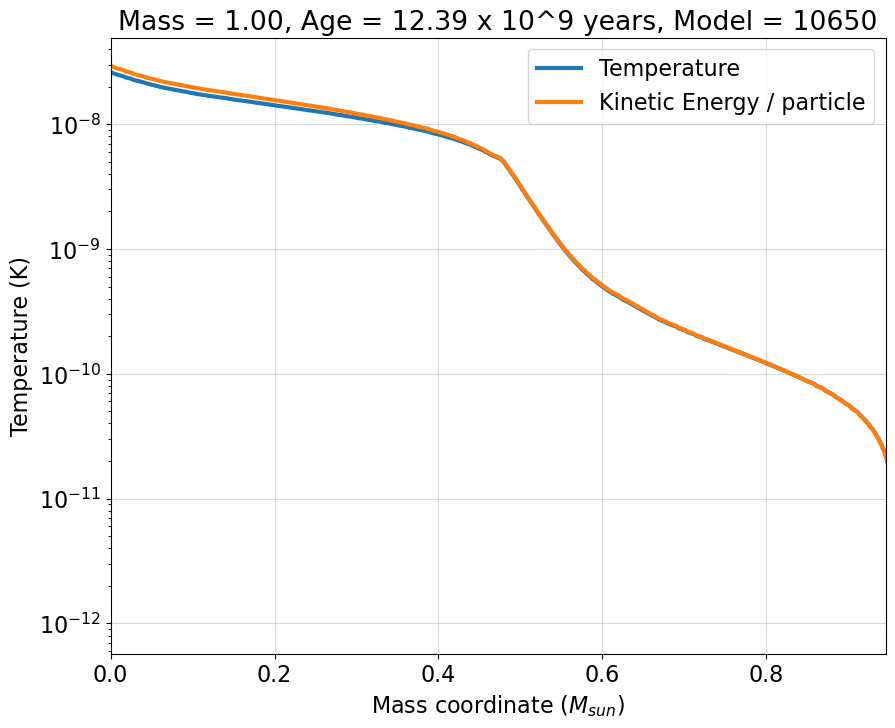

In [335]:
M = 1
history = load_history(M)


profile = load_profile(M, modelnum=10650)  
plot_profile_vs_mass_coord(ax_profile_temp, history, profile) 




$$\frac{N_a}{N_b} \propto e^{\, \Delta E \, / \, kT}$$

d

$$ \frac{3}{2} kT = \frac{KE}{N} $$ 

d 

$$ \frac{3}{2} kT << \frac{KE}{N} $$ 

d

$$ P = \frac{2}{3} \frac{KE}{V} $$ 
